In [2]:
import pandas as pd 
from data_loading import load_tabular_data, preprocess_data
from NN import NN
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
from GenDataset import GenDataset
from DVGS import DVGS

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvrl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('standard', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

In [3]:
model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid)
dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)

In [4]:
for n,p in model.named_parameters():
    print(n)

f.0.weight
f.0.bias
f.3.weight
f.3.bias
f.4.weight
f.4.bias


In [5]:
torch.cuda.is_available()

True

In [7]:
dvs = dvgs.run(crit           = torch.nn.BCELoss(), 
               similarity     = torch.nn.CosineSimilarity(dim=0), 
               optim          = torch.optim.Adam, 
               lr             = 1e-2, 
               num_epochs     = 100, 
               compute_every  = 10, 
               batch_size     = 512, 
               num_workers    = 1, 
               grad_params    = None, 
               verbose        = True, 
               use_cuda       = False)

using device: cpu


In [3]:
dist = torch.distributions.Bernoulli(torch.tensor([0.1, 0.3, 0., 0.99]))

In [6]:
dist.sample()

tensor([0., 0., 0., 1.])

In [310]:
sim_vals1 = sim_vals

In [7]:
c = np.zeros((1000))
c[noise_idx] = 1
res = pd.DataFrame({'dv1':sim_vals.mean(axis=1), 'dv2':sim_vals1.mean(axis=1), 'corrupted':c})
#res.head()
res.corr('spearman')

NameError: name 'sim_vals1' is not defined

In [8]:
plt.figure()
sbn.scatterplot(x='dv1', y='dv2', hue='corrupted', data=res)
plt.show()

NameError: name 'res' is not defined

<Figure size 640x480 with 0 Axes>

In [67]:
sim_vals = dvs

In [68]:
c_true = np.ones(1000, dtype=float)
c_true[noise_idx] = 0.
aucs = []
for i in range(sim_vals.shape[1]): 
    x = sim_vals[:, i]
    z = (x - min(x))/(max(x) - min(x))
    aucs.append( roc_auc_score(c_true, z) )

    

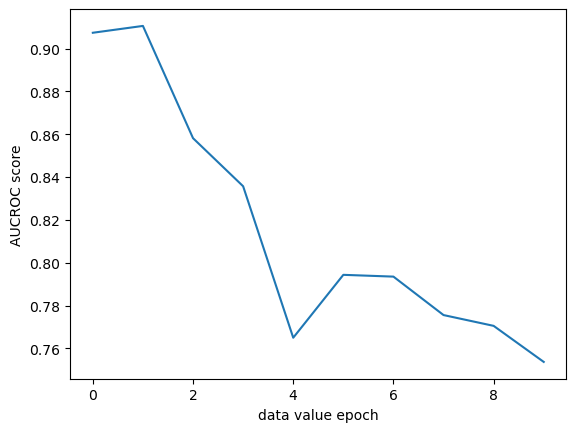

In [69]:
plt.figure()
plt.plot(aucs)
plt.xlabel('data value epoch')
plt.ylabel('AUCROC score')
plt.show()

In [70]:
not_noise_idx = np.delete(np.arange(1000), noise_idx)

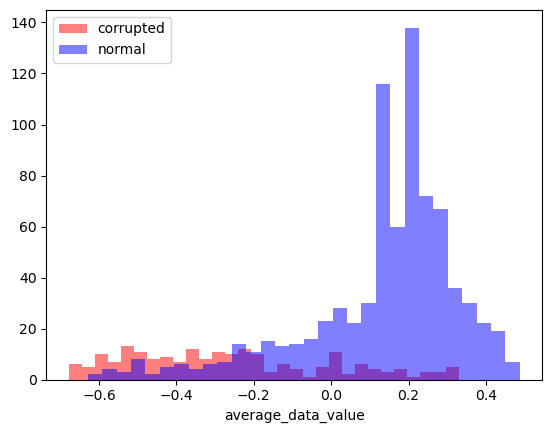

In [71]:
plt.figure()
plt.hist(sim_vals.mean(axis=1)[noise_idx], color='r', label='corrupted', alpha=0.5, bins=30)
plt.hist(sim_vals.mean(axis=1)[not_noise_idx], color='b', label='normal', alpha=0.5, bins=30)
plt.xlabel('average_data_value')
plt.legend()
plt.show()

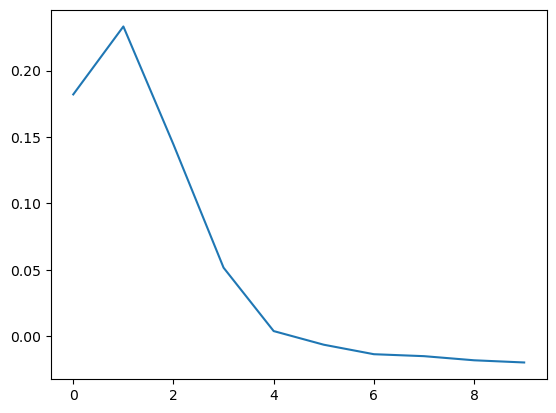

In [72]:
plt.figure()
plt.plot(sim_vals.mean(axis=0))
plt.show()

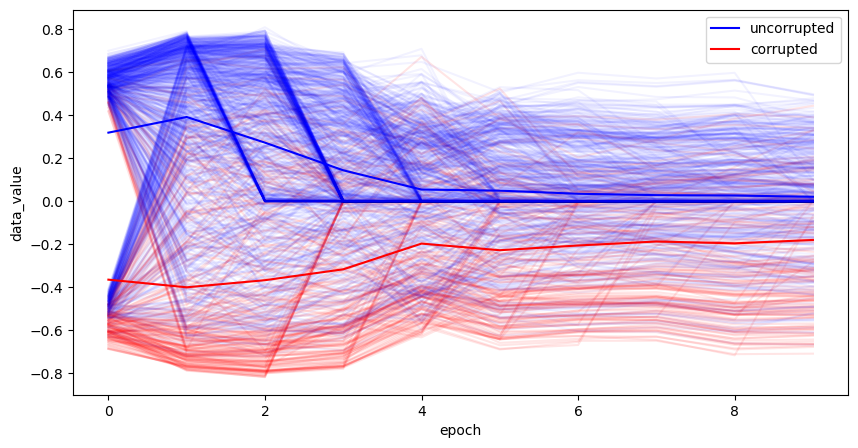

In [73]:
plt.figure(figsize=(10,5))
plt.plot(sim_vals[noise_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals[not_noise_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals[not_noise_idx, :].T.mean(axis=1), color='b', alpha=1., label='uncorrupted')
plt.plot(sim_vals[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.legend()
plt.show()

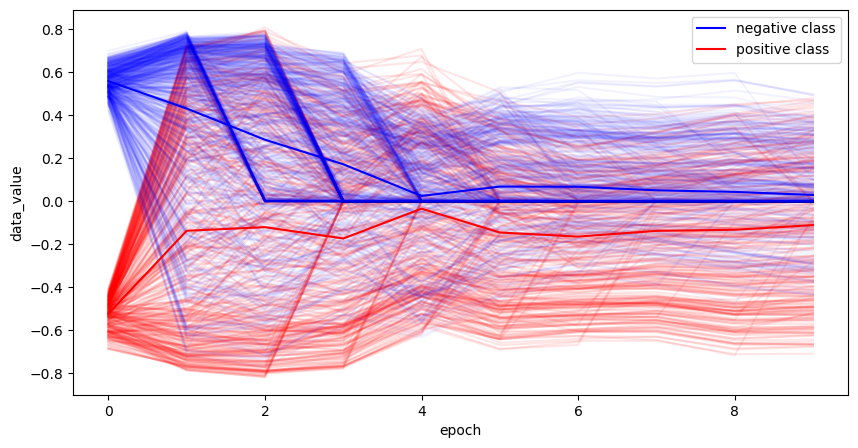

In [74]:
pos_idx = y_train.nonzero()[0].ravel()
neg_idx = np.delete(np.arange(1000), pos_idx)

plt.figure(figsize=(10,5))
plt.plot(sim_vals[pos_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals[neg_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals[neg_idx, :].T.mean(axis=1), color='b', alpha=1., label='negative class')
plt.plot(sim_vals[pos_idx, :].T.mean(axis=1), color='r', alpha=1., label='positive class')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.legend()
plt.show()

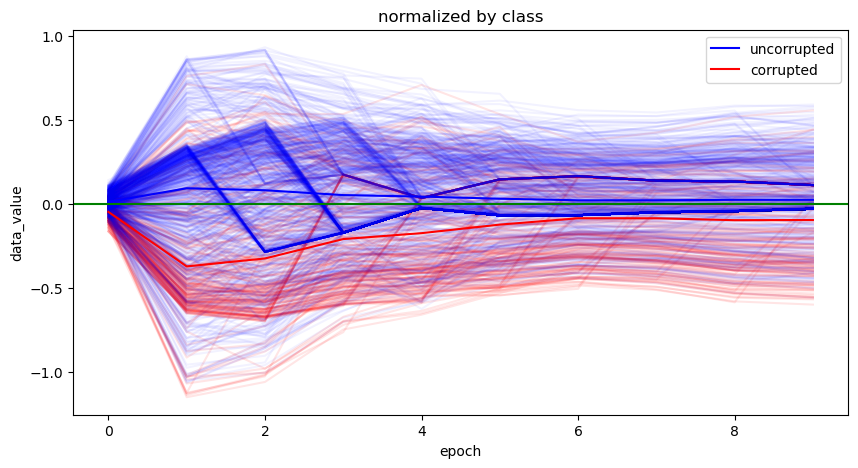

In [75]:
pos_avg_sim = sim_vals[pos_idx, :].mean(axis=0)
neg_avg_sim = sim_vals[neg_idx, :].mean(axis=0)

sim_vals2 = sim_vals.copy()
sim_vals2[pos_idx, :] -= pos_avg_sim.reshape(-1,1).T
sim_vals2[neg_idx, :] -= neg_avg_sim.reshape(-1,1).T

plt.figure(figsize=(10,5))
plt.plot(sim_vals2[noise_idx, :].T, color='r', alpha=0.1)
plt.plot(sim_vals2[not_noise_idx, :].T, color='b', alpha=0.05)
plt.plot(sim_vals2[not_noise_idx, :].T.mean(axis=1), color='b', alpha=1., label='uncorrupted')
plt.plot(sim_vals2[noise_idx, :].T.mean(axis=1), color='r', alpha=1., label='corrupted')
plt.xlabel('epoch')
plt.ylabel('data_value')
plt.title('normalized by class')
plt.legend()
plt.axhline(0, color='g')
plt.show()

In [76]:

ks = np.linspace(1,500,500)
n_corrupt = []
n_perfect = [] 
n_random = [] 

dvs = sim_vals.mean(axis=1)
for k in ks: 
    idx = np.argpartition(dvs, int(k))[:int(k)]
    n_corrupt.append( len(set(noise_idx).intersection(set(idx)))/200 ) 
    n_perfect.append(min(int(k), 200)/200)
    n_random.append(k*0.2/200)


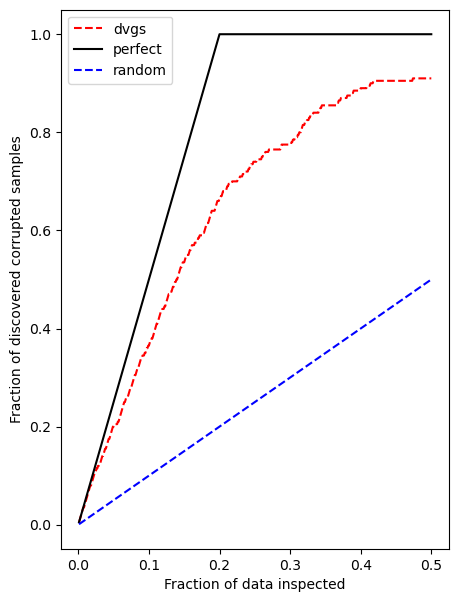

In [77]:
plt.figure(figsize=(5, 7))
plt.plot(ks/1000, n_corrupt, 'r--', label='dvgs')
plt.plot(ks/1000, n_perfect, 'k-', label='perfect')
plt.plot(ks/1000, n_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.show()

In [234]:
def train_model(x_train, y_train, x_test, y_test, epochs=200): 

    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=0.1, bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid)

    crit = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters())

    for epoch in range(epochs): 

        optim.zero_grad()
        yhat_train = model(x_train).squeeze()
        loss = crit(yhat_train, y_train)
        loss.backward()
        optim.step()

    yhat_test = 1. * (model(x_test).detach().numpy() > 0.5).ravel()
    y_test = y_test.detach().numpy().ravel()

    acc = (yhat_test == y_test).sum() / y_test.shape[0]

    return acc

In [235]:
ks = np.linspace(0,500,25)
dvs = sim_vals.mean(axis=1)
high_accs = []
low_accs = []

for k in ks: 
    print(int(k), end='\r')
    sorted_idx = np.argsort(dvs)

    high_idxs = sorted_idx[0:(1000-int(k))]
    low_idxs = sorted_idx[(int(k)):]


    high_accs.append(train_model(x_train[high_idxs, :], y_train[high_idxs], x_test, y_test, epochs=500))
    low_accs.append(train_model(x_train[low_idxs, :], y_train[low_idxs], x_test, y_test, epochs=500))


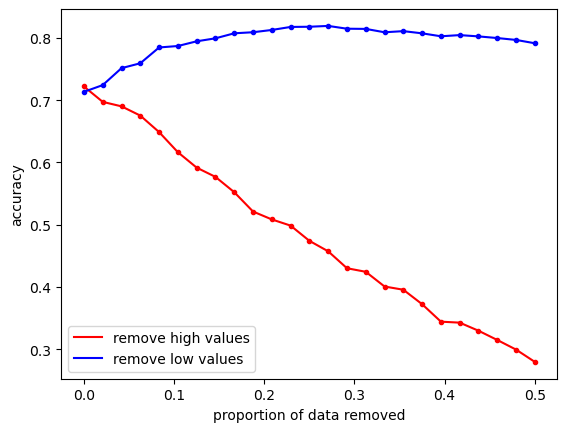

In [236]:
plt.figure()
plt.plot(ks/1000, high_accs, 'r-', label='remove high values')
plt.plot(ks/1000, high_accs, 'r.',)
plt.plot(ks/1000, low_accs, 'b-', label='remove low values')
plt.plot(ks/1000, low_accs, 'b.')
plt.legend()
plt.xlabel('proportion of data removed')
plt.ylabel('accuracy')
plt.show()